In [107]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import lightgbm          as lgb
import xgboost           as xgb
import mlflow
import pickle
import shap
import os

sys.path.append(r'/home/saim/External_Functions')

from scipy                   import stats
from iminuit                 import Minuit
from imblearn.over_sampling  import ADASYN
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.ensemble        import IsolationForest
from ExternalFunctions       import Chi2Regression
from scipy.stats             import norm, lognorm, skewnorm, poisson
from ExternalFunctions       import nice_string_output, add_text_to_ax
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn                 import metrics
from sklearn.preprocessing   import StandardScaler
from sklearn.decomposition   import PCA
from sklearn.preprocessing   import OneHotEncoder
from catboost                import CatBoostClassifier
from catboost                import CatBoost

In [2]:
# Plotting style and colors
plt.style.reload_library()
plt.rcParams['font.size'] = 18 
plt.style.use(['science', 'notebook', 'grid'])

pink = '#e377c2'
blue = '#1f77b4'
golden = '#ff7f0e'
green = '#2ca02c'
red = '#d62728'
purple = '#9467bd'
light_blue = '#17becf'

In [4]:
df = pd.read_csv(r"/home/saim/Desktop/cs.csv")

# Exploratory Data Analysis

In [5]:
print(df.shape)
df.head()

(150000, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
# Looking at data types and null values
print('Datatypes:', '\n', df.dtypes, '\n')
print('Null values:', '\n', df.isna().sum())

Datatypes: 
 Unnamed: 0                                int64
SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object 

Null values: 
 Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTime

In [7]:
# Input: dataframe and column of dataframe
# Output: ratio of nulls
def NA_proportion(dataframe, df_column):
    return dataframe[df_column].isna().sum() / len(dataframe)
    

NA_proportion_MonthlyIncome = NA_proportion(df, 'MonthlyIncome')
NA_proportion_NumberOfDependents = NA_proportion(df, 'NumberOfDependents')

print('Proportion missing from Monthly Income:', NA_proportion_MonthlyIncome)
print('Proportion missing from Monthly Income:', NA_proportion_NumberOfDependents)

Proportion missing from Monthly Income: 0.19820666666666667
Proportion missing from Monthly Income: 0.02616


In [8]:
# Looking at value counts of target feature and the ratio of it
print(df['SeriousDlqin2yrs'].value_counts())

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64


In [10]:
print('Imbalance Ratio', round(10026/139974, 3))

Imbalance Ratio 0.072


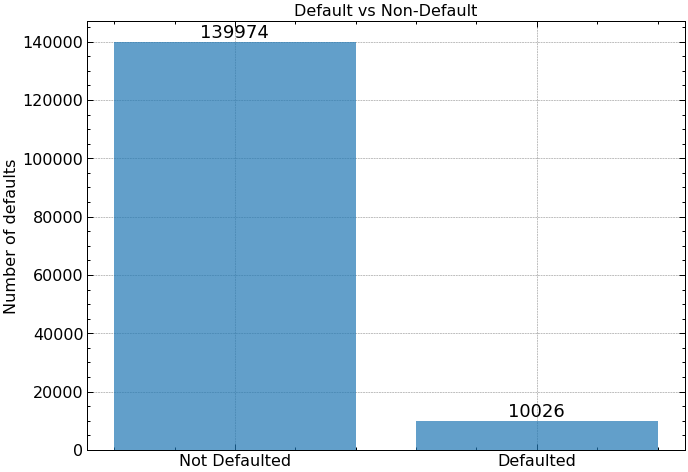

In [11]:
# Plotting the classes

objects = ('Not Defaulted', 'Defaulted')
y_pos = np.arange(len(objects))
performance = np.array([139974, 10026,])


fig, ax = plt.subplots(figsize=(10, 7))
    
plt.bar(y_pos, performance, align='center', alpha= 0.7, color = blue)
plt.xticks(y_pos, objects)
ax.bar_label(ax.containers[0])

plt.ylabel('Number of defaults')
plt.title('Default vs Non-Default')

#plt.savefig("/home/saim/Desktop/defaultsBarChart.png")
fig.tight_layout()

In [12]:
# Looking closer at 'age' feature
df['age'].describe()

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [13]:
# Clearly the min value indicates some data entry erros

In [14]:
# Age distribution investigation
Nbins = 110

age_max = df["age"].max()
age_min = df["age"].min()
binwidth = (age_max - age_min) / Nbins

# Theoretical distributions to fit with. Inputs: PDF parameters - Output: normalized PDF
# Binwidth needs to be changed according to variable being investigated
def func_gaussian_norm(x, N, mu, sigma) :
    return binwidth * N * norm.pdf(x, mu, sigma)

In [15]:
# Input: x-values, number of bins, range
# Output: Binned x and y-values with errors
def hist_data(data, Nbinz, mini, maxi):
    
    counts, bin_edges = np.histogram(data, 
                                     bins = Nbinz, 
                                     range = (mini, maxi), 
                                     density = False)

    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    x = bin_centers[counts > 0]

    y = counts[counts > 0]
    sy = np.sqrt(y)
    
    return x, y, sy

x1, y1, sy1 = hist_data(df['age'], 110, age_min, age_max)

In [17]:
''' 
Input: normalised distribution and its binned x, y and sigma values
Output: Fitting object that can be evaluated
'''
chi2_gaussian = Chi2Regression(func_gaussian_norm, x1, y1, sy1)
chi2_gaussian.errordef = Minuit.LEAST_SQUARES

# Feed Gaussian params as this is the above-defined fitting function
minuit_gaussian = Minuit(chi2_gaussian, 
                         N = 150000,
                         mu = 50, 
                         sigma = 14, 
                         #a = 0.099
                        )

minuit_gaussian.migrad()       # Perform the actual fit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3016                       │              Nfcn = 60               │
│ EDM = 1.4e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  150.0e3  │   0.4e3   │            │            │         │         │       │
│ 1 │ mu    │   51.62   │   0.04    │            │            │         │         │       │
│ 2 │ sigma │  14.930   │   0.026   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         N        mu     sigma │
├───────┼───────────────────────────────┤
│     N │  1.54e+05     -1.07     0.818 │
│    mu │     -1.07   0.00177 -0.000228 │
│ sigma │     0.818 -0.000228  0.000687 │
└───────┴───────────────────────────────┘

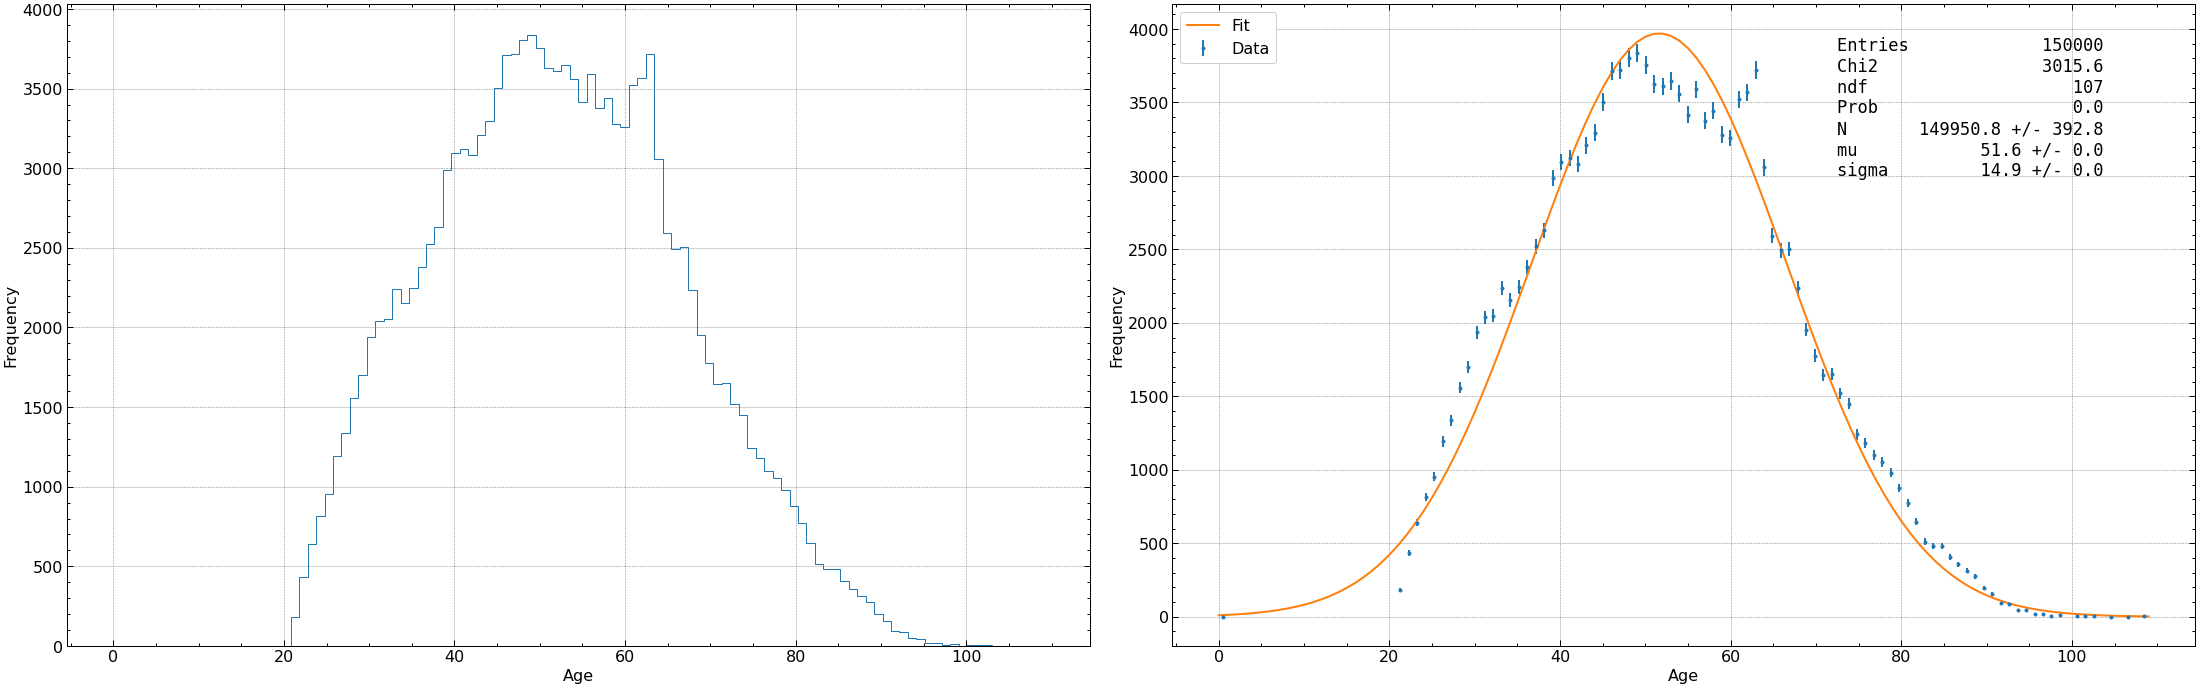

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(31, 10))

# Plot generated data
ax[0].hist(df['age'], 
        bins = 110, 
        #range = (x_min_binom, x_max_binom),
        color = blue,
        histtype = 'step', 
        #label = '1000 samples'
       )

ax[0].set(xlabel = "Age", 
       ylabel = "Frequency", 
       #title = "Samples From the Binomial Distribution of 18 grey marbles out of 25 Tries"
      )

x_axis = np.linspace(age_min, age_max, Nbins)
y_axis = func_gaussian_norm(x_axis, *minuit_gaussian.values[:]
                      )

ax[1].errorbar(x1, y1, sy1, fmt = '.', color = '#1f77b4', label = 'Data')
ax[1].plot(x_axis, y_axis, '-', color = golden, label = 'Fit')

ax[1].set(xlabel = "Age", ylabel = "Frequency", title = "")
ax[1].legend(loc = 'upper left', fontsize = 16);

# Fitting results
chi2_value = minuit_gaussian.fval
Ndof = Nbins - minuit_gaussian.nfit
chi2_prob = stats.chi2.sf(chi2_value, Ndof)


# Define figure text
d = {'Entries': len(df["age"]),
         'Chi2':       chi2_value,
         'ndf':        Ndof,
         'Prob':       chi2_prob,
    }

    
for name in minuit_gaussian.parameters:
    d[name] = [minuit_gaussian.values[name], minuit_gaussian.errors[name]]
    
text = nice_string_output(d, extra_spacing = 1, decimals = 1)
add_text_to_ax(0.65, 0.95, text, ax[1], fontsize = 17)

#plt.savefig("/home/saim/Desktop/age_notNormal.png")
fig.tight_layout()

[Text(0.5, 0, 'Income'), Text(0, 0.5, 'Frequency')]

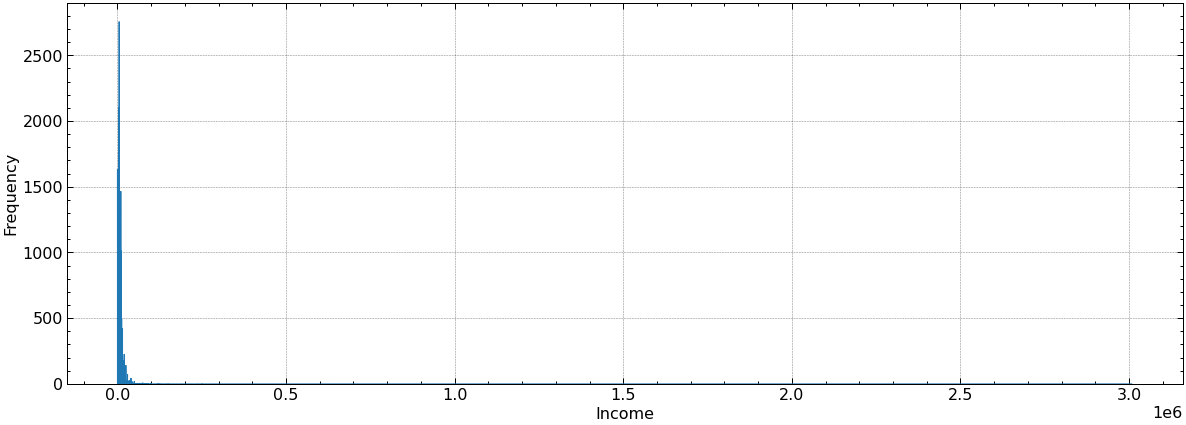

In [19]:
fig, ax = plt.subplots(figsize=(20, 7))

# Plot generated data
ax.hist(df['MonthlyIncome'], 
        bins = 10000000, 
        color = blue,
        histtype = 'step', 
       )

ax.set(xlabel = "Income", 
       ylabel = "Frequency", 
      )

In [20]:
# Looking at kurtosis to confirm that most data is in low-income range
for column in df.columns:
    print("Kurtosis  ",column, ": %f" % df[column].kurt())

Kurtosis   Unnamed: 0 : -1.200000
Kurtosis   SeriousDlqin2yrs : 10.033103
Kurtosis   RevolvingUtilizationOfUnsecuredLines : 14544.713410
Kurtosis   age : -0.494669
Kurtosis   NumberOfTime30-59DaysPastDueNotWorse : 522.376545
Kurtosis   DebtRatio : 13734.288858
Kurtosis   MonthlyIncome : 19504.705403
Kurtosis   NumberOfOpenCreditLinesAndLoans : 3.091067
Kurtosis   NumberOfTimes90DaysLate : 537.738945
Kurtosis   NumberRealEstateLoansOrLines : 60.476808
Kurtosis   NumberOfTime60-89DaysPastDueNotWorse : 545.682744
Kurtosis   NumberOfDependents : 3.001657


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


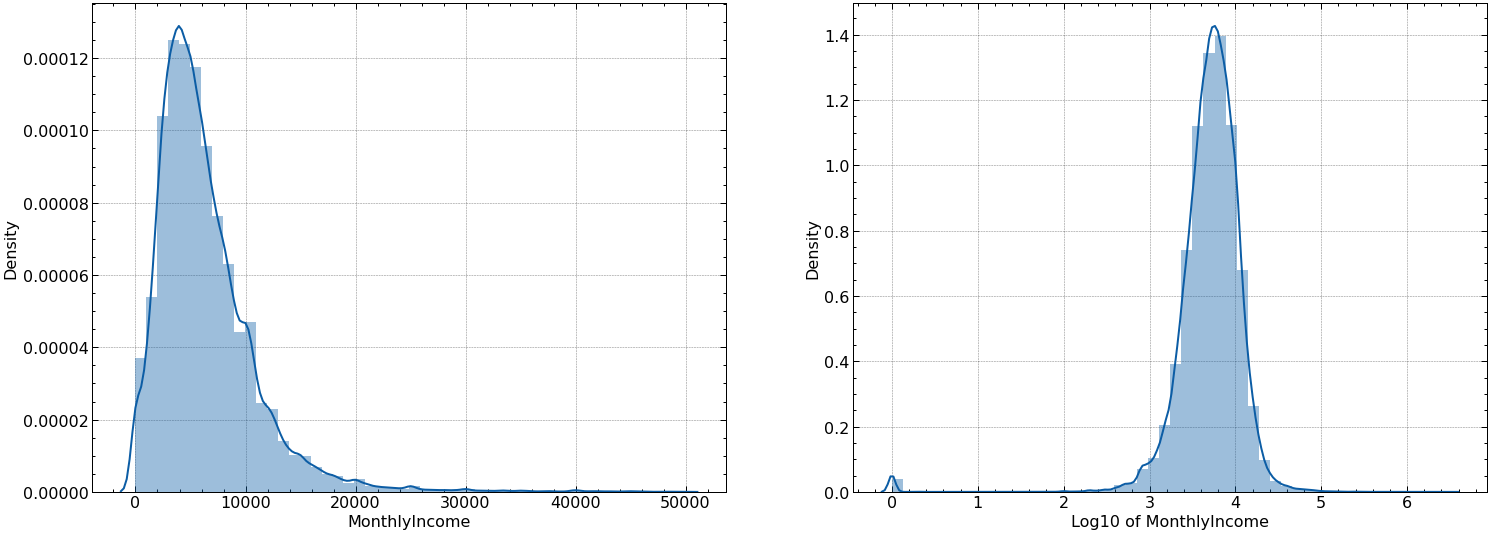

In [21]:
# Plotting the low-income range and a logplot 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(25, 9))
monthly = df.copy()

# Zoomed in monthly income plot
sns.distplot(monthly["MonthlyIncome"].loc[monthly["MonthlyIncome"]<0.5e5].dropna(), 
                        ax = ax[0]);
# Global log plot
df_train_mod = monthly.loc[monthly["MonthlyIncome"]!=0.0].dropna().copy()
df_train_mod["MonthlyIncome"] = np.log10(df_train_mod["MonthlyIncome"])
g = sns.distplot(df_train_mod["MonthlyIncome"], ax = ax[1]);
g.axes.set_xlabel("Log10 of MonthlyIncome");

In [34]:
df.corr()['SeriousDlqin2yrs']

Unnamed: 0                              0.002801
SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines   -0.001802
age                                    -0.115386
NumberOfTime30-59DaysPastDueNotWorse    0.125587
DebtRatio                              -0.007602
MonthlyIncome                          -0.019746
NumberOfOpenCreditLinesAndLoans        -0.029669
NumberOfTimes90DaysLate                 0.117175
NumberRealEstateLoansOrLines           -0.007038
NumberOfTime60-89DaysPastDueNotWorse    0.102261
NumberOfDependents                      0.046048
Name: SeriousDlqin2yrs, dtype: float64

In [ ]:
plt.figure(figsize=(12,2))

sns.heatmap(df.corr(), annot=True, fmt=".2g")

# Data Cleaning

In [90]:
# Start ML Flow experiment

mlflow.set_tracking_uri("http://localhost:5000/#/experiments/4")

experiment_name = 'Credit Risk Modelling' 
mlflow.set_experiment(experiment_name)

mlflow.start_run()
print(mlflow.get_tracking_uri())

http://localhost:5000/#/experiments/4


In [91]:
# Drop Unnamed col
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [95]:
''' 
Drops NAN values
'''
def drop_NAN(dataframe, column_name):
    df_dropped = dataframe.dropna(subset = [column_name])
    return df_dropped

# NumberOfDependents is removed since NAN's only account for 2% of values
df = drop_NAN(df, 'NumberOfDependents')      # df1 = first transformation

In [96]:
# Monthly income is filled where NA and mode imputed where too salary unreasonably high

df.loc[:, 'MonthlyIncome'].fillna((df.loc[:, 'MonthlyIncome'].mode()[0]), inplace=True)
df.loc[df.MonthlyIncome > 90000, 'MonthlyIncome'] = df['MonthlyIncome'].median()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
''' 
Gets rows under a defined threshold
'''

def get_under_thresh(df, col_name, threshold):
    
    df['under_thresh'] = df[col_name] >= threshold
    df = df[df['under_thresh'] == False]
    df.drop(['under_thresh'], axis = 1, inplace = True)
    print('Max value of column:', df[col_name].max())
    
    return df

In [97]:
# ratios must be <= 1
df2 = get_under_thresh(df, 'RevolvingUtilizationOfUnsecuredLines', 2)
df2 = get_under_thresh(df, 'DebtRatio', 2)

# df.where replaces value where condition is false
#df2['RevolvingUtilizationOfUnsecuredLines'].where(
    #df2['RevolvingUtilizationOfUnsecuredLines'] <= 1, 1, inplace = True)

#print(df2['RevolvingUtilizationOfUnsecuredLines'].max())

df2.where(df2.loc[:, 'DebtRatio'] <= 1, 1, inplace = True)
print('debt max', df2['DebtRatio'].max())

df2 = df2[df2['RevolvingUtilizationOfUnsecuredLines'] < 1]
print('revolver max', df2['RevolvingUtilizationOfUnsecuredLines'].max())


df2 = df2[df2['age'] > 1]
print('age min', df2['age'].min())

Max value of column: 1.99867586
Max value of column: 1.998765432
debt max 1.0
revolver max 0.9999999
age min 21



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Feature Engineering

In [98]:
def feature_eng(df):
    
    # MonthlyIncomePerPerson: Monthly Income divided by the number of dependents
    df['MonthlyIncomePerPerson'] = df['MonthlyIncome'] / (df['NumberOfDependents']+1)
    df['MonthlyIncomePerPerson'].fillna(0, inplace=True)
    
    # isRetired: age is greater than 67 (Assumed Retirement Age)
    df['isRetired'] = np.where((df['age'] > 67), 1, 0)
    
    # Interquantile ranges of MonthlyIncome
    df['Q1_Monthly_Income'] = df['MonthlyIncome'] <= df['MonthlyIncome'].quantile(0.25)
    df['Q3_Monthly_Income'] = df['MonthlyIncome'] >= df['MonthlyIncome'].quantile(0.75)
    #df['Q2_Monthly_Income'] = df['MonthlyIncome'].between(3400, 8249)
    
 

    # Interquantile ranges of Revolving...
    df['Q1_Revolving'] = df['RevolvingUtilizationOfUnsecuredLines'] <= df['RevolvingUtilizationOfUnsecuredLines'].quantile(0.25)
    df['Q3_Revolving'] = df['RevolvingUtilizationOfUnsecuredLines'] >= df['RevolvingUtilizationOfUnsecuredLines'].quantile(0.75)

    df = pd.get_dummies(df, columns = ['Q1_Monthly_Income', 
                                       'Q3_Monthly_Income',
                                       'Q1_Revolving', 
                                       'Q3_Revolving'
                                      ], 
                        drop_first = True
                       )
    
    return df

df3 = feature_eng(df2)

In [99]:
print(df2.shape)
df3.head()

(111771, 17)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncomePerPerson,isRetired,Q1_Monthly_Income_True,Q3_Monthly_Income_True,Q1_Revolving_True,Q3_Revolving_True
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,3040.0,0,0,1,0,1
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,1300.0,0,1,0,0,1
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,3042.0,0,1,0,0,1
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,3300.0,0,1,0,0,0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,63588.0,0,0,1,0,1


# Modelling

In [100]:
X = df3.iloc[:, 1:]
y = df3.iloc[:, 0:1]


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    shuffle = True
                                                   )
print(X_train.shape)
print(X_test.shape)

(89416, 16)
(22355, 16)


In [101]:
# export train/test split to csv

X_train_csv = X_train.to_csv(r"/home/saim/Desktop/X_train.csv", index=False)
X_test_csv = X_test.to_csv(r"/home/saim/Desktop/X_test.csv", index=False)

y_train_csv = y_train.to_csv(r"/home/saim/Desktop/y_train.csv", index=False)
y_test_csv = y_test.to_csv(r"/home/saim/Desktop/y_test.csv", index=False)

In [102]:
random_undersampler = RandomUnderSampler(random_state = 42)
X_res, y_res = random_undersampler.fit_resample(X_train, y_train)

print(X_res.shape)
print(y_res.shape)

(10744, 16)
(10744, 1)


In [103]:
# gets relevant evaluation metrics

def evaluation(model, model_name):
    prediction = model.predict(X_test)
    probabilities = model.predict_proba(X_test)
    
    fpr, tpr, thresh = metrics.roc_curve(y_test, probabilities[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    class_report = metrics.classification_report(y_test, prediction)
    
    print(model_name, 'AUC:', round(roc_auc, 3), '\n', class_report)
    
    return prediction, probabilities, roc_auc, tpr, fpr, class_report

## XGBoost

In [104]:
# XGBoost modelling

xgb_model = xgs.XGBClassifier(use_label_encoder = False,
                              learning_rate = 0.7, 
                              max_depth = 10, 
                              n_estimators = 100, 
                              reg_alpha = 0.5, 
                              reg_lambda = 0.2,
                              colsample_bytree = 1, 
                              colsample_bylevel = 0.2, 
                              colsample_bynode = 1, 
                              scale_pos_weight = 21
                             )

# parameter optimization
grid_params = {'learning_rate' : list(np.arange(0.0, 1.0, 0.1)),
               'max_depth': [i for i in range(15)],
               'n_estimators' : [i for i in range(50, 1000, 50)],
               'reg_alpha' : list(np.arange(0.0, 1.0, 0.1)), 
               'reg_lambda' : list(np.arange(0.0, 1.0, 0.1)),
               'colsample_bytree' : list(np.arange(0.0, 1.0, 0.1)),
               'colsample_bylevel' : list(np.arange(0.0, 1.0, 0.1)),
               'colsample_bynode' : list(np.arange(0.0, 1.0, 0.1)),
               'scale_pos_weight' : [i for i in range(30)]
              }

xgb_optimized = RandomizedSearchCV(xgb_model, 
                               param_distributions = grid_params, 
                               random_state = 42, 
                               cv = 5
                              )

xgb_optimized.fit(X_res, y_res.values.ravel(), eval_metric = 'rmse')

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=0.2,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.7,
                                           max_delta_step=None, max_depth=10,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_es...
                                                         500, 550, 600, 650,
                                                         700

In [105]:
print(xgb_optimized.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=0.2, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=950, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=2,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [110]:
xgb_final = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=0.2, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=14,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=950, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=2,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

xgb_final.fit(X_res, y_res.values.ravel(), eval_metric = 'rmse')

# eval metrics
xgb_pred, xgb_proba, xgb_roc_auc, xgb_tpr, xgb_fpr, xgb_report = evaluation(xgb_final, 'XGBoost')

XGBoost AUC: 0.807 
               precision    recall  f1-score   support

           0       0.98      0.72      0.83     20965
           1       0.15      0.75      0.25      1390

    accuracy                           0.72     22355
   macro avg       0.56      0.73      0.54     22355
weighted avg       0.93      0.72      0.79     22355



## Light GBM

In [111]:
lgbm_model = lgb.LGBMClassifier(boosting_type = 'gbdt', 
                                   objective = 'binary', 
                                   learning_rate = 0.1, 
                                   random_state = 42
                                  )

# parameter optimization
lgbm_grid_params = {
                    'learning_rate' : list(np.arange(0.0, 1.0, 0.1)),
                    'max_depth': [i for i in range(15)],
                    'num_leaves': [i for i in range(100)],
                    'n_estimators' : [i for i in range(50, 1000, 50)],
                    'subsample_for_bin': [i for i in range (1000000, 10000000, 1000000)],
                    'reg_alpha' : list(np.arange(0.0, 1.0, 0.1)), 
                    'reg_lambda' : list(np.arange(0.0, 1.0, 0.1)),
                    'colsample_bytree' : list(np.arange(0.0, 1.0, 0.1)),
                    }

lgbm_optimized = RandomizedSearchCV(lgbm_model, 
                               param_distributions = lgbm_grid_params, 
                               random_state = 42, 
                               cv = 5
                              )

lgbm_optimized.fit(X_res, y_res.values.ravel(), eval_metric = 'rmse')

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .

[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .

[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=42),
                   param_distributions={'colsample_bytree': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'learning_rate': [0.0, 0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5,
                                                          0.6000000000000001,
                                                          0.7000000000000001,
          

In [112]:
print(lgbm_optimized.best_estimator_)

LGBMClassifier(colsample_bytree=0.2, learning_rate=0.6000000000000001,
               max_depth=1, n_estimators=850, num_leaves=49, objective='binary',
               random_state=42, reg_alpha=0.9, reg_lambda=0.4,
               subsample_for_bin=5000000)


In [113]:
lgbm_final = lgb.LGBMClassifier(colsample_bytree=0.2, learning_rate=0.6000000000000001,
               max_depth=1, n_estimators=850, num_leaves=49, objective='binary',
               random_state=42, reg_alpha=0.9, reg_lambda=0.4,
               subsample_for_bin=5000000)


lgbm_final.fit(X_res, y_res.values.ravel(), eval_metric = 'rmse')

# eval metrics
lgbm_pred, lgbm_proba, lgbm_roc_auc, lgbm_tpr, lgbm_fpr, lgbm_report = evaluation(lgbm_final, 'Light GBM')

Light GBM AUC: 0.845 
               precision    recall  f1-score   support

           0       0.98      0.79      0.88     20965
           1       0.19      0.74      0.30      1390

    accuracy                           0.79     22355
   macro avg       0.59      0.77      0.59     22355
weighted avg       0.93      0.79      0.84     22355



## Cat Boost

In [114]:
cat_model = CatBoostClassifier(iterations = 2, depth = 2)

# parameter optimization
cat_grid_params = {
                    'learning_rate' : list(np.arange(0.0, 1.0, 0.1)),
                    'depth': [i for i in range(17)],
                    'bagging_temperature': [i for i in range(1000)],
                    'l2_leaf_reg' : list(np.arange(0.0, 1.0, 0.1)),
                    }

cat_optimized = RandomizedSearchCV(cat_model, 
                               param_distributions = cat_grid_params, 
                               random_state = 42, 
                               cv = 5
                              )

cat_optimized.fit(X_res, y_res.values.ravel())

0:	learn: 0.5169808	total: 91.8ms	remaining: 91.8ms
1:	learn: 0.4784975	total: 136ms	remaining: 0us
0:	learn: 0.5216952	total: 10.6ms	remaining: 10.6ms
1:	learn: 0.4830117	total: 103ms	remaining: 0us
0:	learn: 0.5207206	total: 69.3ms	remaining: 69.3ms
1:	learn: 0.4809012	total: 113ms	remaining: 0us
0:	learn: 0.5191191	total: 40.8ms	remaining: 40.8ms
1:	learn: 0.4765571	total: 78.3ms	remaining: 0us
0:	learn: 0.5193654	total: 75ms	remaining: 75ms
1:	learn: 0.4769634	total: 123ms	remaining: 0us
0:	learn: 0.5607570	total: 80.4ms	remaining: 80.4ms
1:	learn: 0.5066433	total: 168ms	remaining: 0us
0:	learn: 0.5636440	total: 3.62ms	remaining: 3.62ms
1:	learn: 0.5056505	total: 88.4ms	remaining: 0us
0:	learn: 0.5605574	total: 90.6ms	remaining: 90.6ms
1:	learn: 0.5039336	total: 192ms	remaining: 0us
0:	learn: 0.5599107	total: 78.3ms	remaining: 78.3ms
1:	learn: 0.5023645	total: 169ms	remaining: 0us
0:	learn: 0.5626885	total: 84.2ms	remaining: 84.2ms
1:	learn: 0.5057480	total: 173ms	remaining: 0us
0:


5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/saim/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/saim/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 4768, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/saim/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 2073, in _fit
    train_params = self._prepare_train_params(
  File "/home/saim/anaconda3/lib/py

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f54552945e0>,
                   param_distributions={'bagging_temperature': [0, 1, 2, 3, 4,
                                                                5, 6, 7, 8, 9,
                                                                10, 11, 12, 13,
                                                                14, 15, 16, 17,
                                                                18, 19, 20, 21,
                                                                22, 23, 24, 25,
                                                                26, 27, 28, 29, ...],
                                        'depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                  10, 11, 12, 13, 14, 15, 16],
                                        'l2_leaf_reg': [0.0, 0.1, 0.2,
                                                        0.30000000000000004,
              

In [115]:
cat_pred, cat_proba, cat_roc_auc, cat_tpr, cat_fpr, cat_report = evaluation(cat_optimized, 'CatBoost')

CatBoost AUC: 0.838 
               precision    recall  f1-score   support

           0       0.98      0.75      0.85     20965
           1       0.17      0.78      0.28      1390

    accuracy                           0.75     22355
   macro avg       0.58      0.77      0.57     22355
weighted avg       0.93      0.75      0.82     22355



In [116]:
with open(r'xgb_model.pickle', 'wb') as f:
    pickle.dump(xgb_final, f)

with open(r'lgbm_model.pickle', 'wb') as f:
    pickle.dump(lgbm_final, f)

with open(r'cat_model.pickle', 'wb') as f:
    pickle.dump(cat_optimized, f)

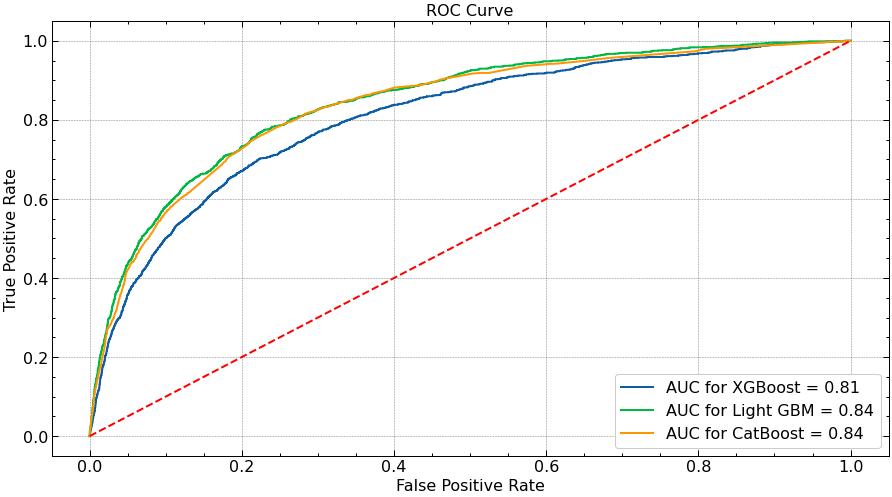

In [118]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(xgb_fpr, xgb_tpr, label = 'AUC for XGBoost = %0.2f' % xgb_roc_auc)
ax.plot(lgbm_fpr, lgbm_tpr, label = 'AUC for Light GBM = %0.2f' % lgbm_roc_auc)
ax.plot(cat_fpr, cat_tpr, label = 'AUC for CatBoost = %0.2f' % cat_roc_auc)

ax.plot([0, 1], [0, 1],'r--')

ax.set(xlabel = "False Positive Rate", ylabel = "True Positive Rate")
ax.legend(loc = 'lower right')
    
plt.savefig("ROC.png")
mlflow.log_artifact("ROC.png")

plt.savefig("/home/saim/Desktop/model_perf.png")
plt.title('ROC Curve')
plt.show()

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


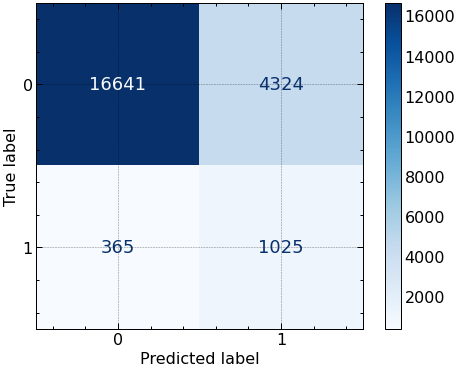

In [131]:
metrics.plot_confusion_matrix(lgbm_final, X_test, y_test, cmap="Blues")

#plt.savefig("/home/saim/Desktop/conf.png")
plt.show()

In [ ]:
# Log model
mlflow.xgboost.log_model(xgb_model = xgb_final, 
                         artifact_path = '',
                         #registered_model_name = 'Baseline'
                        )

# Log parameters
mlflow.log_params({'use_label_encoder' : 'False'})
mlflow.log_params({'learning_rate' : '0.7'})
mlflow.log_params({'max_depth' : '10'})
mlflow.log_params({'n_estimators' : '100'})
mlflow.log_params({'reg_alpha' : '0.5'})
mlflow.log_params({'reg_lambda' : '0.2'})
mlflow.log_params({'booster' : 'gbtree'})
mlflow.log_params({'colsample_bytree' : '1'})
mlflow.log_params({'colsample_bylevel' : '0.2'})
mlflow.log_params({'colsample_bynode' : '1'})
mlflow.log_params({'scale_pos_weight' : '21'})


# Log conda environment
conda_env = mlflow.xgboost.get_default_conda_env()

# Log confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_xgb)
t_n, f_p, f_n, t_p = cm.ravel()

mlflow.log_metric("True Negative", t_n)
mlflow.log_metric("False Positive", f_p)
mlflow.log_metric("False Negative", f_n)
mlflow.log_metric("True Positive", t_p)


# Log classification report
xgb_report = pd.DataFrame(metrics.classification_report(y_test, y_pred_xgb, output_dict = True)).transpose()
xgb_report.to_csv('classification_report.csv', index = True)
mlflow.log_artifact('classification_report.csv')

# Log roc_auc
fpr, tpr, thresh = metrics.roc_curve(y_test, probability_xgb[:,1])
roc_auc = metrics.auc(fpr, tpr)
mlflow.log_metric('AUC', roc_auc)

# Log f1
f1 = metrics.f1_score(y_test, y_pred_xgb)
mlflow.log_metric('f1', f1)

# Log precision
precision = metrics.precision_score(y_test, y_pred_xgb)
mlflow.log_metric('precision', precision)

# Log recall 
recall = metrics.recall_score(y_test, y_pred_xgb)
mlflow.log_metric('recall', recall)

mlflow.end_run()

## Explainability

In [119]:
# Calculate SHAP values
tree_explainer = shap.TreeExplainer(lgbm_final)
shap_values = tree_explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


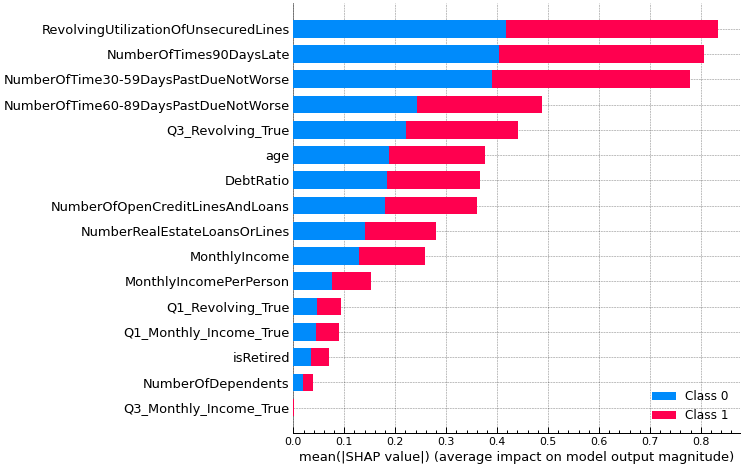

In [120]:
shap_barz = shap.summary_plot(shap_values, 
                              X_train, 
                              axis_color = '#000000', 
                              show = False
                             )

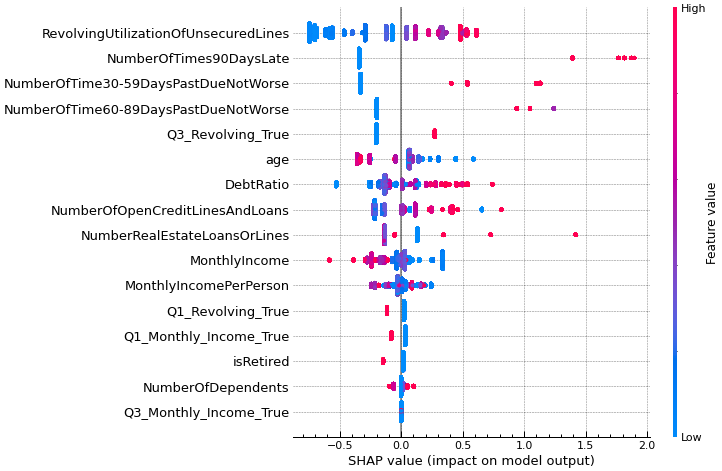

In [121]:
shap.summary_plot(shap_values[1], 
                  X_train, 
                  axis_color = '#000000', 
                  show = False
                 )

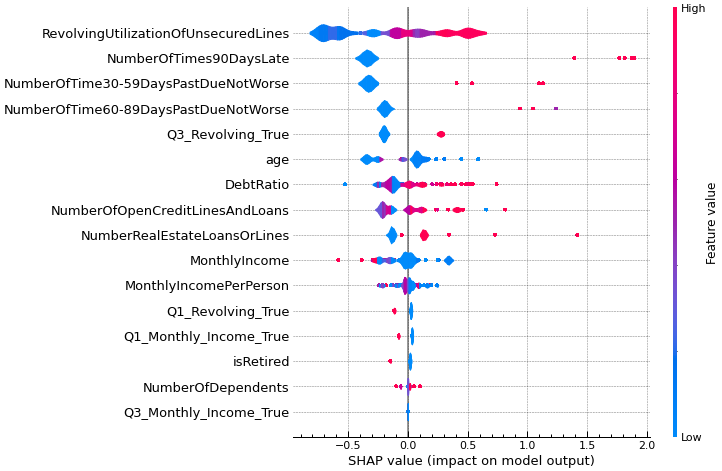

In [122]:
shap.summary_plot(shap_values[1], 
                  X_train, 
                  axis_color = '#000000', 
                  show = False,
                  plot_type='violin'
                 )